# **Projet 8 : Réalisez un dashboard et assurez une veille technique**

L’objectif de cette partie est de réaliser un **état de l’art sur une technique récente de modélisation de données textuelles**, publiée depuis moins de cinq ans, afin d’évaluer son **apport par rapport à une méthode plus classique** déjà mise en œuvre dans un projet précédent (Projet 6).

Dans ce cadre, nous avons choisi d’étudier **INSTRUCTOR** (*Instruction-Finetuned Text Embeddings*), une approche récente permettant de produire des **embeddings sémantiques orientés par une instruction de tâche**, et de la comparer à une méthode plus classique basée sur **Sentence-BERT (SBERT)**.

Cette veille technique vise à :
- approfondir la compréhension des méthodes récentes d’embeddings de texte,
- évaluer leur pertinence opérationnelle dans un cadre industriel,
- mesurer leur apport sur un cas d’usage réel déjà connu : la **classification d’articles e-commerce** issue du Projet 6.

# 📚 Sommaire

0. Import des librairies et fonctions utilitaires  
1. Présentation et exploration du jeu de données  
2. Préparation et nettoyage des textes  
3. Analyse descriptive des catégories  
4. Séparation Train / Validation / Test
5. Baseline : SBERT (Sentence-BERT – MiniLM)  
6. Veille technique : INSTRUCTOR (Instruction-based embeddings)  
7. Comparaison des performances  
8. Discussion des résultats, limites et perspectives  
9. Conclusion

### **0. Import des librairies et fonctions utilitaires** 

Cette section regroupe :
- les librairies standards de manipulation de données,
- les outils NLP classiques (NLTK),
- les modèles d’embeddings,
- ainsi que des fonctions utilitaires utilisées pour la visualisation et l’analyse exploratoire (réduction de dimension, t-SNE, clustering).

Certaines fonctions sont héritées des expérimentations menées dans le Projet 6 et sont conservées ici à des fins de continuité méthodologique.

In [38]:
# Imports standards
import numpy as np
import pandas as pd

from pathlib import Path
from collections import Counter
from time import perf_counter

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# NLP classique 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Machine Learning / Clustering 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Métriques de clustering 
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure
)

# Modèles d'embeddings
from sentence_transformers import SentenceTransformer
from InstructorEmbedding import INSTRUCTOR
import torch

# Outils math / optimisation
from scipy import sparse
from scipy.optimize import linear_sum_assignment

# Qualité des données 
import missingno as msno

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Nettoyage minimal du texte
def minimal_clean(text: str) -> str:
    """
    Nettoyage léger :
    - minuscule
    - suppression retours ligne / tabulations
    - suppression espaces multiples

    Aucun filtrage sémantique agressif
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = text.replace("\n", " ").replace("\t", " ")
    text = " ".join(text.split())

    return text


In [4]:
# Réduction de dimension générique (PCA si dense, TruncatedSVD si sparse)
def reduce_dimensionality(X, n_components=50, random_state=42, scale_after=True):
    """
    Réduction de dimension :
    - TruncatedSVD si matrice sparse
    - PCA si matrice dense
    """
    n_components = max(
        2,
        min(n_components, X.shape[1] - 1 if X.shape[1] > 1 else 1)
    )

    if sparse.issparse(X):
        X_red = TruncatedSVD(
            n_components=n_components,
            random_state=random_state
        ).fit_transform(X)

        if scale_after:
            X_red = StandardScaler().fit_transform(X_red)

        return X_red

    else:
        X_scaled = StandardScaler().fit_transform(np.asarray(X))
        return PCA(
            n_components=n_components,
            random_state=random_state
        ).fit_transform(X_scaled)

In [5]:
# t-SNE pour la visualisation (sur l’espace réduit) : calcule une projection 2D non linéaire
def tsne_embed(X_red, perplexity=30, random_state=42, metric="euclidean"):
    """
    Projection t-SNE en 2D
    """
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        metric=metric,
        random_state=random_state
    )
    return tsne.fit_transform(X_red)


In [6]:
# KMeans (sur t-SNE)
def kmeans_clustering(X_tsne, k, n_init=50, random_state=42):
    return KMeans(
        n_clusters=k,
        n_init=n_init,
        random_state=random_state
    ).fit_predict(X_tsne)


In [7]:
# ALignement clusters <--> catégories (algorithme hongrois)
def align_clusters_hungarian(df):
    """
    Aligne clusters et catégories réelles (1–1)
    via l'algorithme hongrois
    """

    contingency = pd.crosstab(df["cluster"], df["category"])

    row_ind, col_ind = linear_sum_assignment(
        -contingency.values
    )

    cluster_to_cat = {
        contingency.index[r]: contingency.columns[c]
        for r, c in zip(row_ind, col_ind)
    }

    df["cluster_aligned"] = df["cluster"].map(cluster_to_cat)

    return df, cluster_to_cat


In [8]:
CATEGORY_COLORS = {
    "Home Furnishing": "#1f77b4",          # bleu
    "Baby Care": "#ff7f0e",                # orange
    "Watches": "#2ca02c",                  # vert
    "Home Decor & Festive Needs": "#d62728",# rouge
    "Kitchen & Dining": "#9467bd",         # violet
    "Beauty and Personal Care": "#8c564b", # marron
    "Computers": "#e377c2",                # rose
}


In [9]:
# Visualisation t-SNE (réel vs clusters)
def plot_tsne_side_by_side(
    df,
    cluster_palette,
    title=""
):
    fig, axes = plt.subplots(
        1, 2,
        figsize=(16, 6),
        sharex=True,
        sharey=True
    )

    # Catégories réelles
    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue="category",
        palette=CATEGORY_COLORS,
        s=50,
        ax=axes[0]
    )
    axes[0].set_title(f"Catégories réelles {title}")
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    # Clusters
    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue="cluster",
        palette=cluster_palette,
        s=50,
        ax=axes[1]
    )
    axes[1].set_title(f"Clusters KMeans {title}")
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


In [10]:
# Pipeline global de clustering & évaluation (ARI, temps)
def run_clustering_pipeline(
    X,
    y_true,
    k=None,
    n_components=50,
    perplexity=30,
    random_state=42,
    n_init=50,
    show_plot=True,
    title=""
):
    t0 = perf_counter()

    y_true = np.asarray(y_true).astype(str)
    if k is None:
        k = len(np.unique(y_true))

    # Réduction + t-SNE
    X_red = reduce_dimensionality(
        X,
        n_components=n_components,
        random_state=random_state
    )
    X_tsne = tsne_embed(
        X_red,
        perplexity=perplexity,
        random_state=random_state
    )

    # Clustering
    y_pred = kmeans_clustering(
        X_tsne,
        k=k,
        n_init=n_init,
        random_state=random_state
    )

    # Scores
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)

    # DataFrame visu
    df_visu = pd.DataFrame({
        "x": X_tsne[:, 0],
        "y": X_tsne[:, 1],
        "category": y_true,
        "cluster": y_pred
    })

    df_visu, cluster_to_cat = align_clusters_hungarian(df_visu)

    cluster_palette = {
        cluster: CATEGORY_COLORS[cat]
        for cluster, cat in cluster_to_cat.items()
    }

    if show_plot:
        plot_tsne_side_by_side(
            df_visu,
            cluster_palette,
            title=title
        )

    time_total = perf_counter() - t0

    return {
        "ari": ari,
        "nmi": nmi,
        "homogeneity": h,
        "completeness": c,
        "v_measure": v,
        "time_total_s": time_total,
        "df_visu": df_visu,
        "cluster_to_cat": cluster_to_cat
    }


### **1. Présentation et exploration du jeu de données** 

Les données utilisées dans ce projet sont issues du **Projet 6**, portant sur la classification de produits e-commerce (Flipkart).
Elles contiennent notamment :
- la description textuelle des articles,
- leur catégorie hiérarchique,
- et des informations annexes non exploitées dans cette étude.

L’objectif est de conserver un **cas d’usage identique** afin de comparer uniquement l’impact du changement de méthode d’embedding.

#### 1.1. Chargement du dataset

In [11]:
DATA_PATH = Path(
    "C:/Users/marga/Documents/Openclassrooms/_Projet_6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
)

In [13]:
data = pd.read_csv(DATA_PATH)
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


#### 1.2. Structure générale du dataset

In [15]:
print("Nombre de lignes :", data.shape[0])
print("Nombre de colonnes :", data.shape[1])

Nombre de lignes : 1050
Nombre de colonnes : 15


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

#### 1.3. Qualité des données

- Valeurs manquantes 

In [ ]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

<Axes: >

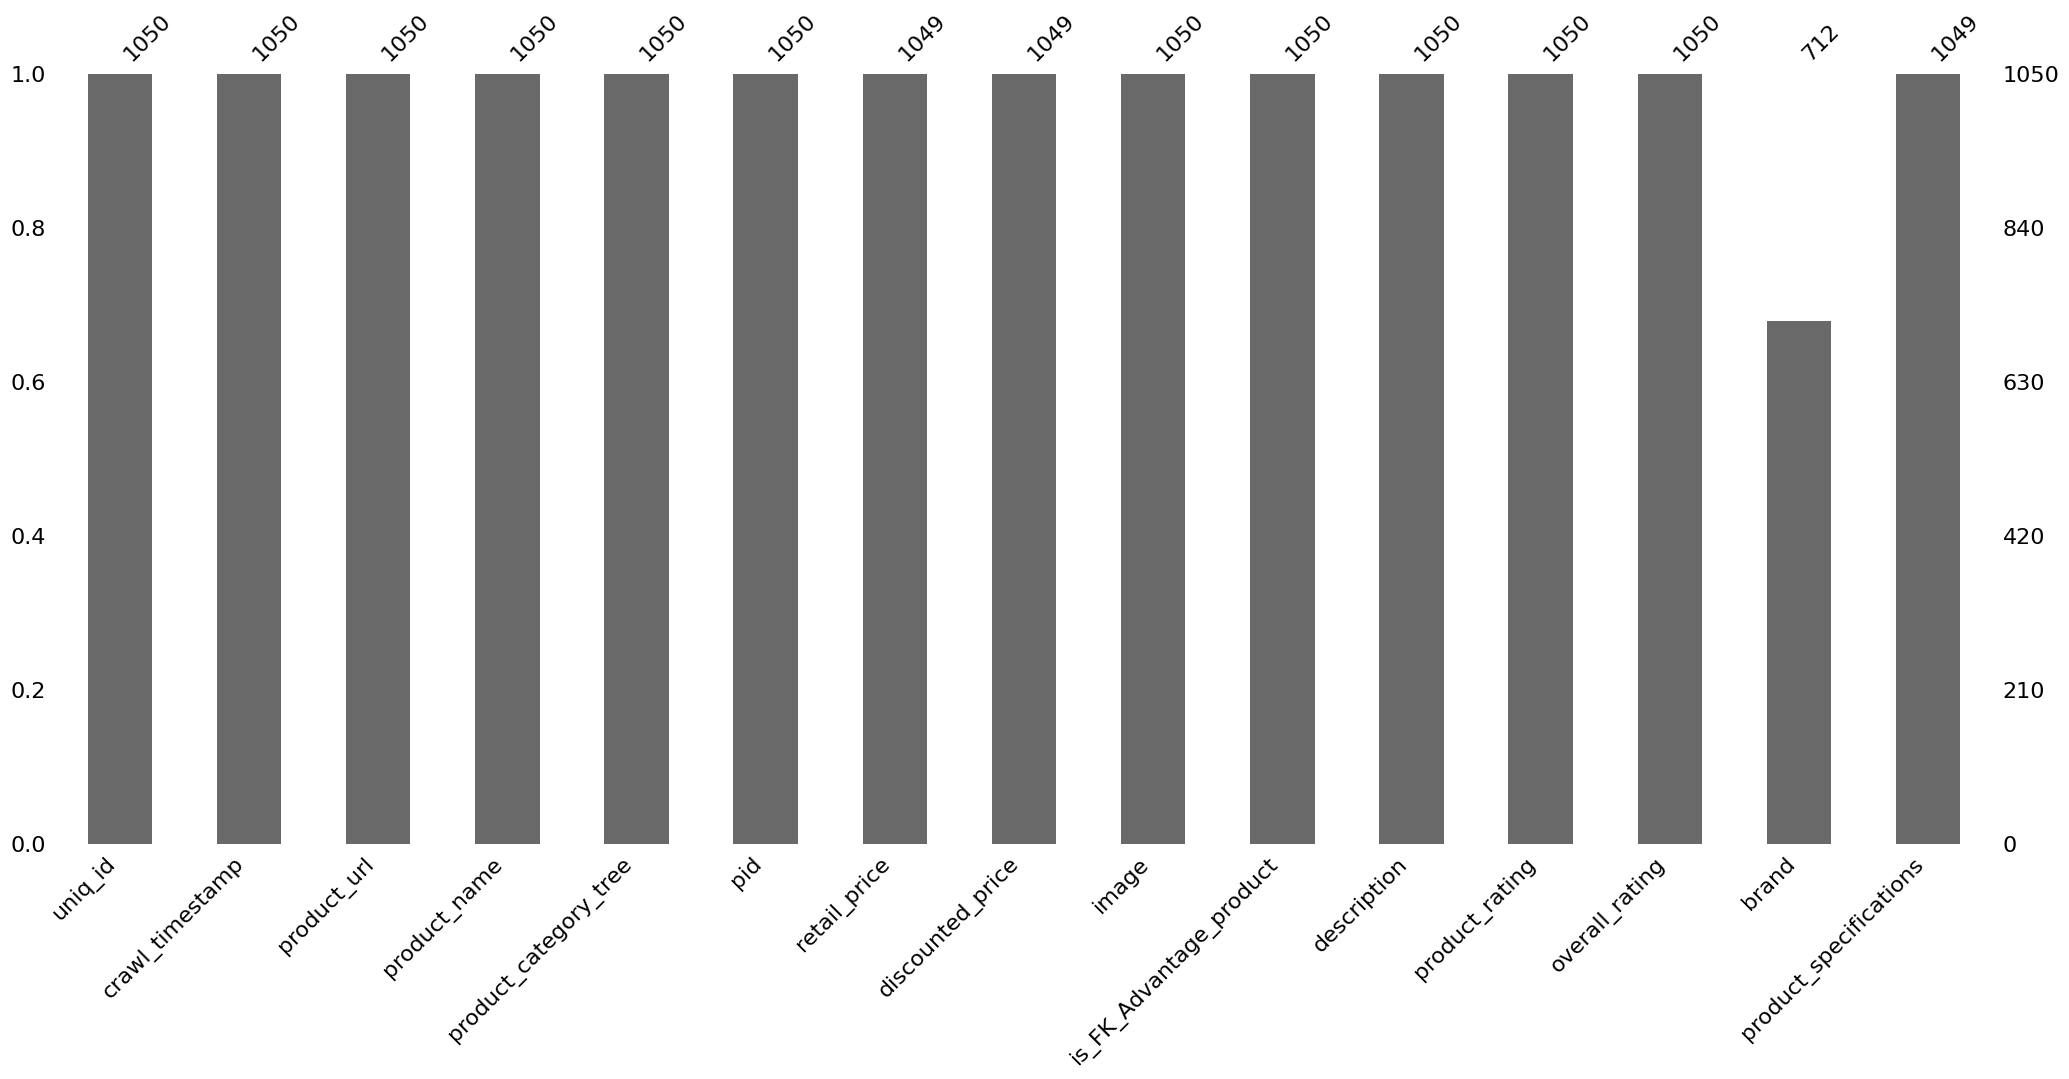

In [19]:
msno.bar(data)

In [20]:
total_missing = data.isnull().sum().sum()
taux_remplissage = 1 - total_missing / data.size

print(f"Taux de remplissage global : {taux_remplissage:.2%}")


Taux de remplissage global : 97.83%


- Doublons

In [21]:
print("Nombre de doublons :", data.duplicated().sum())

Nombre de doublons : 0


#### 1.4. Création de la catégorie principale

In [22]:
data["main_category"] = (
    data["product_category_tree"]
    .astype(str)
    .apply(lambda x: x.split(">>")[0].strip('[" '))
)

data["main_category"].value_counts()



main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

#### 1.5. Répartition des catégories

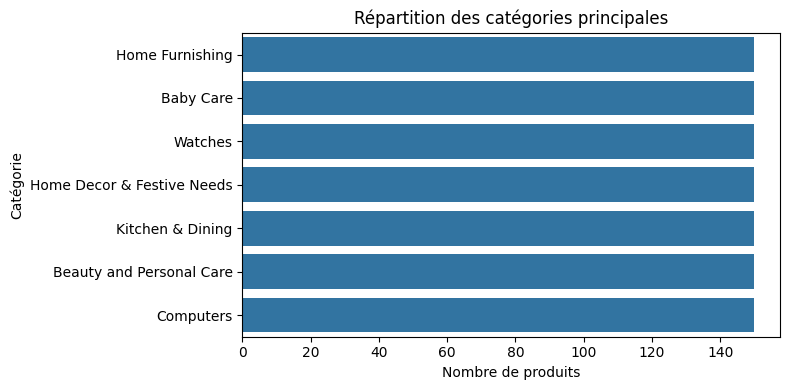

In [23]:
plt.figure(figsize=(8, 4))
sns.countplot(
    y=data["main_category"],
    order=data["main_category"].value_counts().index
)
plt.title("Répartition des catégories principales")
plt.xlabel("Nombre de produits")
plt.ylabel("Catégorie")
plt.tight_layout()
plt.show()

### **2. Préparation et nettoyage des textes** 

In [24]:
data["description"].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

La préparation des textes suit une approche classique en NLP :
- normalisation (minuscule),
- suppression des mots très fréquents et non informatifs,
- lemmatisation.

Cette étape permet de réduire le bruit tout en conservant l’information sémantique utile à la classification.


In [25]:
data["text_clean"] = data["description"].apply(minimal_clean)

data[["description", "text_clean"]].head()

,description,text_clean
0,Key Features of Elegance Polyester Multicolor ...,key features of elegance polyester multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...,specifications of sathiyas cotton bath towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...,key features of eurospa cotton terry face towe...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,key features of santosh royal fashion cotton p...
4,Key Features of Jaipur Print Cotton Floral Kin...,key features of jaipur print cotton floral kin...


In [26]:
# Vérification de la qualité des textes
empty_ratio = (data["text_clean"].str.len() == 0).mean()
print(f"Proportion de descriptions vides : {empty_ratio:.2%}")


Proportion de descriptions vides : 0.00%


In [27]:
# Longueur des descriptions
data["text_clean"].str.len().describe()

count    1050.000000
mean      466.407619
std       451.818693
min        75.000000
25%       190.000000
50%       274.000000
75%       568.250000
max      3488.000000
Name: text_clean, dtype: float64

On n'applique pas de traitement des stopwords, de lemmatisation ou de stemming : ces opérations, utiles pour des représentations bag-of-words, peuvent altérer l’ordre et le contexte des mots. Les modèles SBERT et INSTRUCTOR étant entraînés sur du texte naturel, elles ne sont pas appliquées ici.

In [28]:
# Texte final utilisé pour les embeddings 
X_text = data["text_clean"]
y = data["main_category"]

X_text.head()

0    key features of elegance polyester multicolor ...
1    specifications of sathiyas cotton bath towel (...
2    key features of eurospa cotton terry face towe...
3    key features of santosh royal fashion cotton p...
4    key features of jaipur print cotton floral kin...
Name: text_clean, dtype: object

X_test est l'entrée unique pour nos 2 techniques
y est utilisé uniquement pour l'évaluation

### **3. Analyse descriptive des catégories** 

#### 3.1. Longueur des descriptions

In [29]:
data["text_length"] = data["text_clean"].str.len()

data["text_length"].describe()

count    1050.000000
mean      466.407619
std       451.818693
min        75.000000
25%       190.000000
50%       274.000000
75%       568.250000
max      3488.000000
Name: text_length, dtype: float64

La longueur des descriptions est globalement compatible avec les contraintes des modèles Transformers. Les quelques descriptions très longues peuvent introduire une variabilité intra-catégorie, mais ne constituent pas un obstacle méthodologique.

#### 3.2. Longueur des descriptions par catégorie

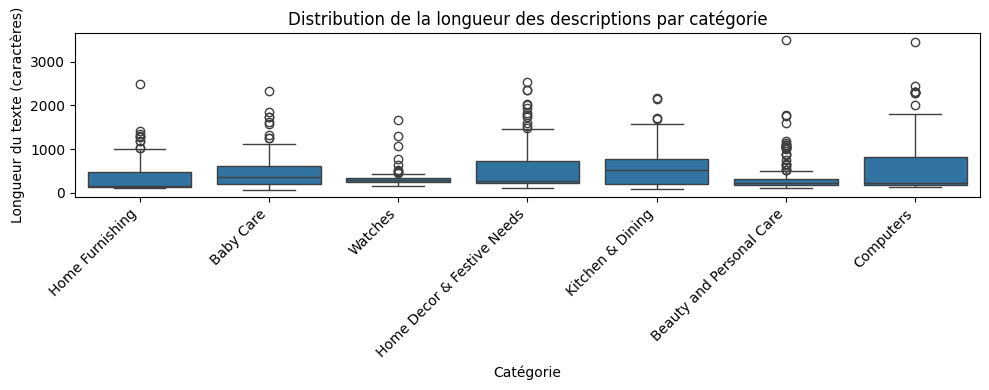

In [30]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=data,
    x="main_category",
    y="text_length"
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution de la longueur des descriptions par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Longueur du texte (caractères)")
plt.tight_layout()
plt.show()


Les catégories *Home Furnishing*, *Home Decor & Festive Needs* et *Computers* plus hétérogènes sont susceptibles de générer des clusters plus diffus ou partiellement chevauchants, ce qui sera analysé lors de la phase de clustering.

#### 3.3. Vocabulaire dominant par catégorie 

In [31]:
stopwords_en = set(stopwords.words("english"))

def tokenize_for_eda(text):
    return [
        w for w in word_tokenize(text)
        if w.isalpha() and len(w) > 2 and w not in stopwords_en
    ]


In [32]:
top_words_per_category = {}

for cat in data["main_category"].unique():
    texts = data.loc[data["main_category"] == cat, "text_clean"]
    tokens = []
    for t in texts:
        tokens.extend(tokenize_for_eda(t))
    top_words_per_category[cat] = Counter(tokens).most_common(10)

top_words_per_category

{'Home Furnishing': [('cotton', 103),
  ('pack', 88),
  ('cover', 80),
  ('buy', 77),
  ('products', 76),
  ('free', 76),
  ('design', 74),
  ('genuine', 74),
  ('shipping', 74),
  ('cash', 74)],
 'Baby Care': [('baby', 316),
  ('cotton', 188),
  ('details', 174),
  ('girl', 165),
  ('fabric', 164),
  ('dress', 105),
  ('specifications', 99),
  ('ideal', 98),
  ('general', 96),
  ('boy', 92)],
 'Watches': [('watch', 324),
  ('analog', 249),
  ('men', 158),
  ('day', 136),
  ('buy', 134),
  ('online', 134),
  ('india', 134),
  ('great', 134),
  ('discounts', 134),
  ('genuine', 134)],
 'Home Decor & Festive Needs': [('showpiece', 204),
  ('products', 90),
  ('best', 87),
  ('free', 83),
  ('buy', 82),
  ('day', 81),
  ('online', 78),
  ('prices', 78),
  ('delivery', 77),
  ('shipping', 76)],
 'Kitchen & Dining': [('mug', 323),
  ('ceramic', 204),
  ('perfect', 143),
  ('mugs', 130),
  ('material', 119),
  ('coffee', 113),
  ('day', 97),
  ('features', 92),
  ('design', 89),
  ('price', 

L’analyse du vocabulaire dominant par catégorie confirme la cohérence sémantique du corpus. Les mots les plus fréquents sont directement liés aux produits décrits, validant la pertinence du texte comme source d’information pour la catégorisation.

### **4. Embeddings SBERT + Clustering non supervisé**

#### 4.1. Choix du modèle SBERT 

On utilise exactement le modèle du Projet 6 pour assurer la comparabilité :
- `sentence-transformers/all-MiniLM-L6-v2`
- Léger, rapide, très bon compromis performance / coût

#### 4.2. Encodage des descriptions (pipeline SBERT)

In [33]:
def sbert_pipeline(
    texts,
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    batch_size=64
):
    t0 = perf_counter()

    model = SentenceTransformer(model_name)

    X_embeddings = model.encode(
        texts.tolist(),
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=False
    )

    time_embedding = perf_counter() - t0

    return X_embeddings, time_embedding


In [34]:
X_sbert, time_sbert_embedding = sbert_pipeline(X_text)

print(f"Temps encodage SBERT : {time_sbert_embedding:.2f} s")
print("Shape embeddings :", X_sbert.shape)


Batches: 100%|██████████| 17/17 [00:11<00:00,  1.53it/s]

Temps encodage SBERT : 11.68 s
Shape embeddings : (1050, 384)


#### 4.3. Clustering et évaluation (ARI)

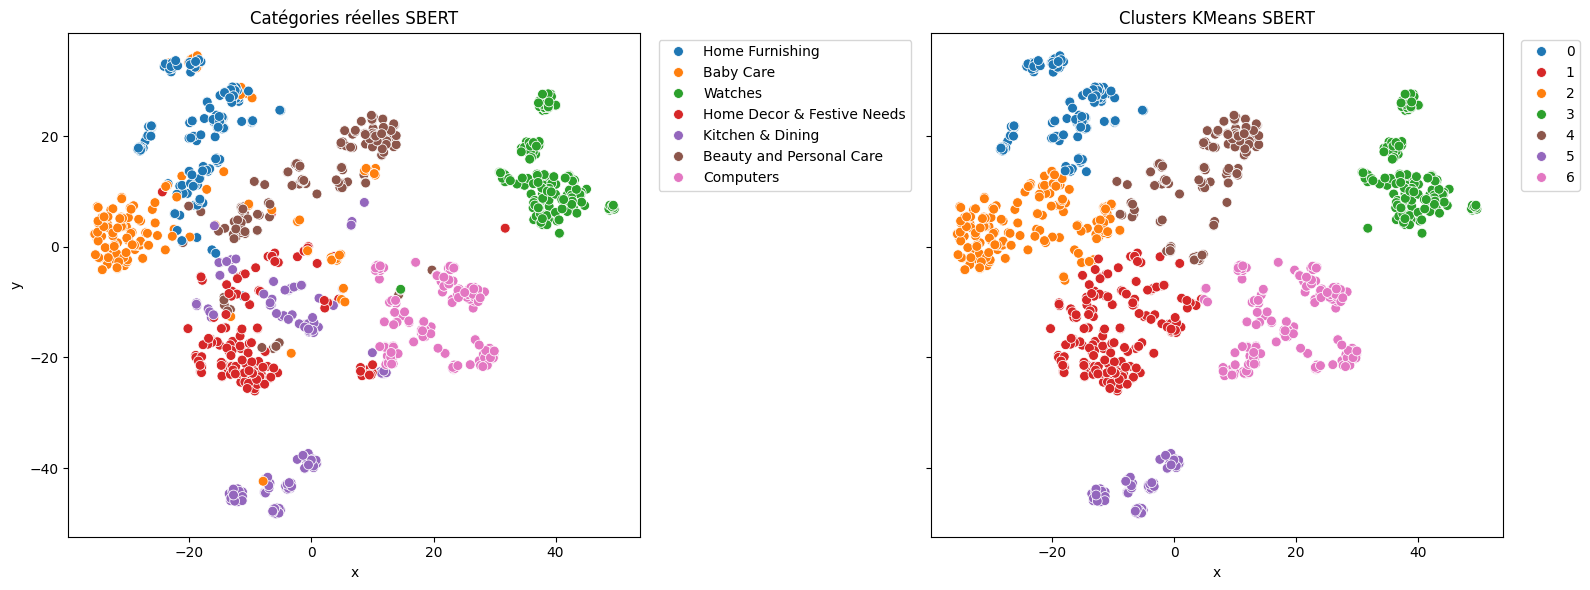

ARI SBERT : 0.612
Temps total SBERT : 20.17 s


In [35]:
res_sbert = run_clustering_pipeline(
    X=X_sbert,
    y_true=y,
    k=7,
    title="SBERT"
)

ari_sbert = res_sbert["ari"]
time_sbert_total = time_sbert_embedding + res_sbert["time_total_s"]

print(f"ARI SBERT : {ari_sbert:.3f}")
print(f"Temps total SBERT : {time_sbert_total:.2f} s")


#### 4.4. Synthèse SBERT

La projection t-SNE montre une structuration claire de l’espace sémantique, avec plusieurs clusters bien séparés correspondant aux catégories réelles, notamment Watches, Computers et Baby Care.
Les chevauchements observés entre certaines catégories (Home Furnishing, Home Decor & Festive Needs, Kitchen & Dining) reflètent des proximités sémantiques réelles plutôt qu’un défaut du modèle.
Avec un ARI de 0.61 et un temps d’exécution total de 20 s, SBERT offre un excellent compromis entre qualité de structuration sémantique et efficacité computationnelle.

### **5. Veille technique : INSTRUCTOR (Instruction-based embeddings)**

*Su et al., 2022 – One Embedder, Any Task: Instruction-Finetuned Text Embeddings*

https://arxiv.org/abs/2212.09741    |    https://instructor-embedding.github.io/

INSTRUCTOR est un modèle d’embeddings entraîné à intégrer explicitement une **instruction de tâche** lors de l’encodage des textes.
Contrairement aux approches classiques où le texte est encodé de manière générique, INSTRUCTOR produit des représentations **orientées par l’objectif final** (classification, recherche d’information, similarité, etc.).

Dans cette étude, l’instruction utilisée est la suivante :

> *"Represent the product description for product category classification"*

Cette formulation permet d’orienter l’espace vectoriel vers la tâche de classification, sans nécessiter de fine-tuning supervisé.


#### 5.1. Pipeline d'encodage INSTRUCTOR

In [39]:
def instructor_pipeline(
    texts,
    instruction,
    model_name="hkunlp/instructor-base",
    batch_size=32
):
    t0 = perf_counter()

    model = INSTRUCTOR(model_name)

    X_embeddings = model.encode(
        [[instruction, t] for t in texts.tolist()],
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=False
    )

    time_embedding = perf_counter() - t0

    return np.array(X_embeddings), time_embedding

In [40]:
INSTRUCTION = "Represent the product description for product category classification"

X_instr, time_instr_embedding = instructor_pipeline(
    X_text,
    instruction=INSTRUCTION
)

print("Shape :", X_instr.shape)
print("Temps :", time_instr_embedding)

load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\sentence_transformers\models\Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mo

max_seq_length  512


Batches: 100%|██████████| 33/33 [01:45<00:00,  3.20s/it]

Shape : (1050, 768)
Temps : 106.97255579987541


#### 5.2. Clustering & évaluation (ARI)

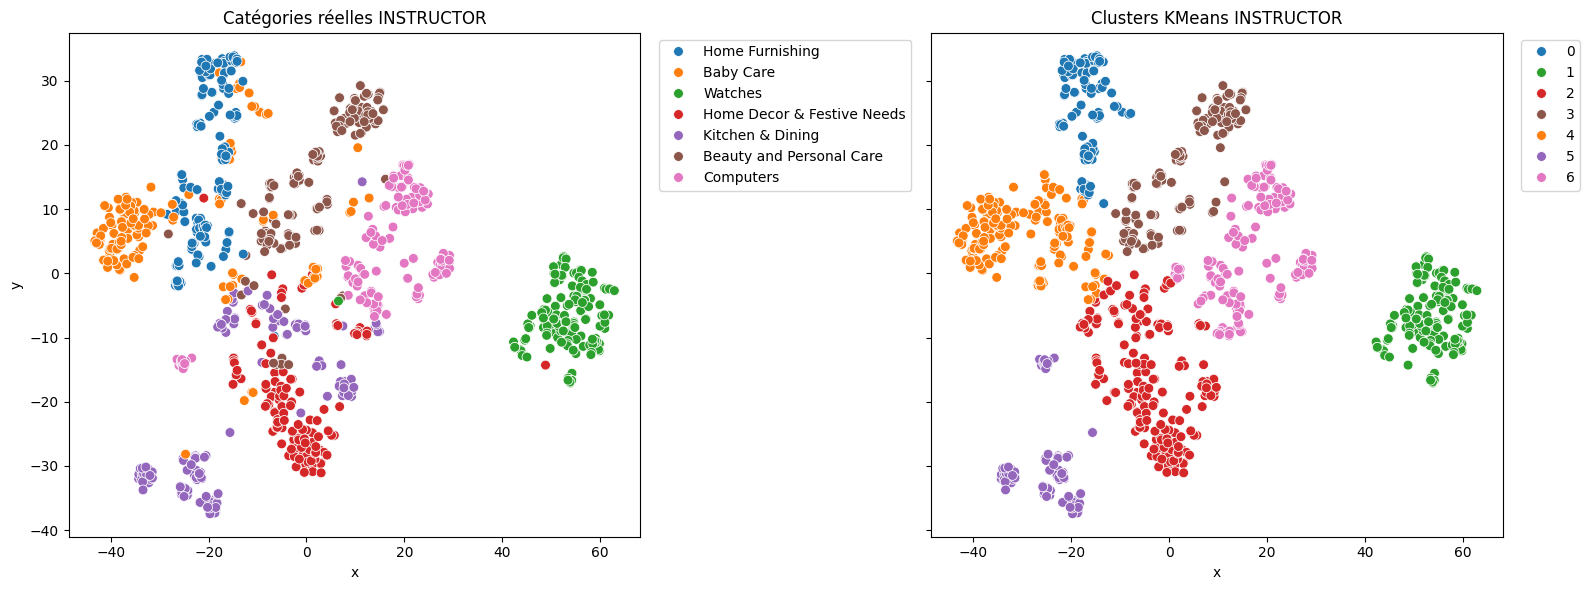

ARI INSTRUCTOR : 0.622
Temps total INSTRUCTOR : 110.81 s


In [41]:
res_instr = run_clustering_pipeline(
    X=X_instr,
    y_true=y,
    k=7,
    title="INSTRUCTOR"
)

ari_instr = res_instr["ari"]
time_instr_total = time_instr_embedding + res_instr["time_total_s"]

print(f"ARI INSTRUCTOR : {ari_instr:.3f}")
print(f"Temps total INSTRUCTOR : {time_instr_total:.2f} s")

#### 5.3. Synthèse INSTRUCTOR

Les embeddings générés par INSTRUCTOR produisent une structuration sémantique globalement comparable à celle observée avec SBERT, avec des clusters bien définis pour les catégories les plus spécifiques telles que Watches et Computers.
L’ARI légèrement supérieur (0.62) indique une cohérence de clustering marginalement meilleure, mais les chevauchements entre catégories proches (Home Furnishing, Home Decor & Festive Needs, Kitchen & Dining) persistent.
En revanche, le temps d’exécution nettement plus élevé (~111 s) limite l’intérêt opérationnel d’INSTRUCTOR dans ce contexte mono-domaine, au regard d’un gain de performance très modéré.

#### 5.4. Analyse de sensibilité à la formulation de l'instruction

Contrairement aux modèles d’embeddings classiques (SBERT), INSTRUCTOR conditionne explicitement la représentation vectorielle par une instruction de tâche. Il est donc pertinent d’évaluer dans quelle mesure la formulation de cette instruction influence la qualité du clustering, mesurée ici par le score ARI.

L’objectif n’est pas d’optimiser finement l’instruction, mais d’évaluer :
- la robustesse du modèle à des reformulations proches,
- l’existence éventuelle d’un gain mesurable selon le niveau de précision de l’instruction.

In [54]:
INSTRUCTIONS = {
    "generic": "Represent the product description",
    "classification": "Represent the product description for classification",
    "category_classification": "Represent the product description for product category classification",
    "ecommerce": "Represent an e-commerce product description for category classification",
    "semantic": "Represent the semantic meaning of the product description for clustering"
}



Instruction : generic
load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

max_seq_length  512


Batches: 100%|██████████| 33/33 [02:14<00:00,  4.08s/it]


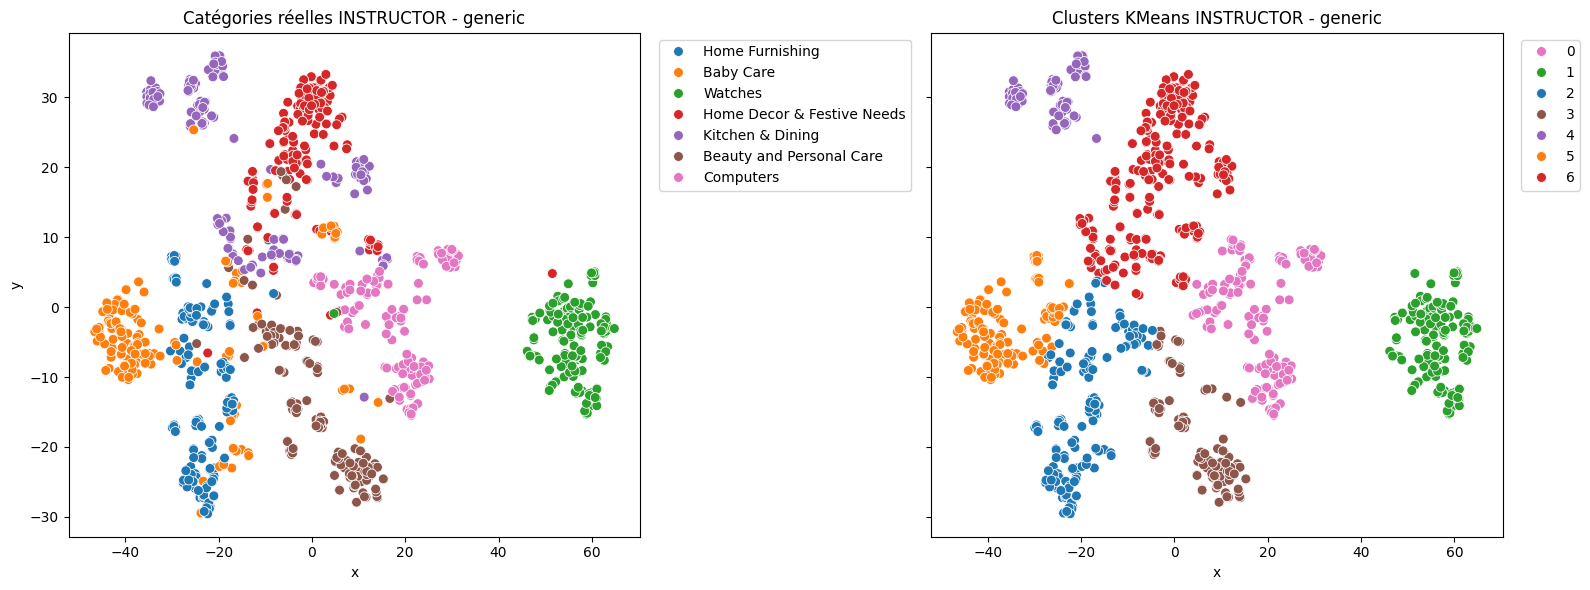


Instruction : classification
load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

max_seq_length  512


Batches: 100%|██████████| 33/33 [06:22<00:00, 11.58s/it]


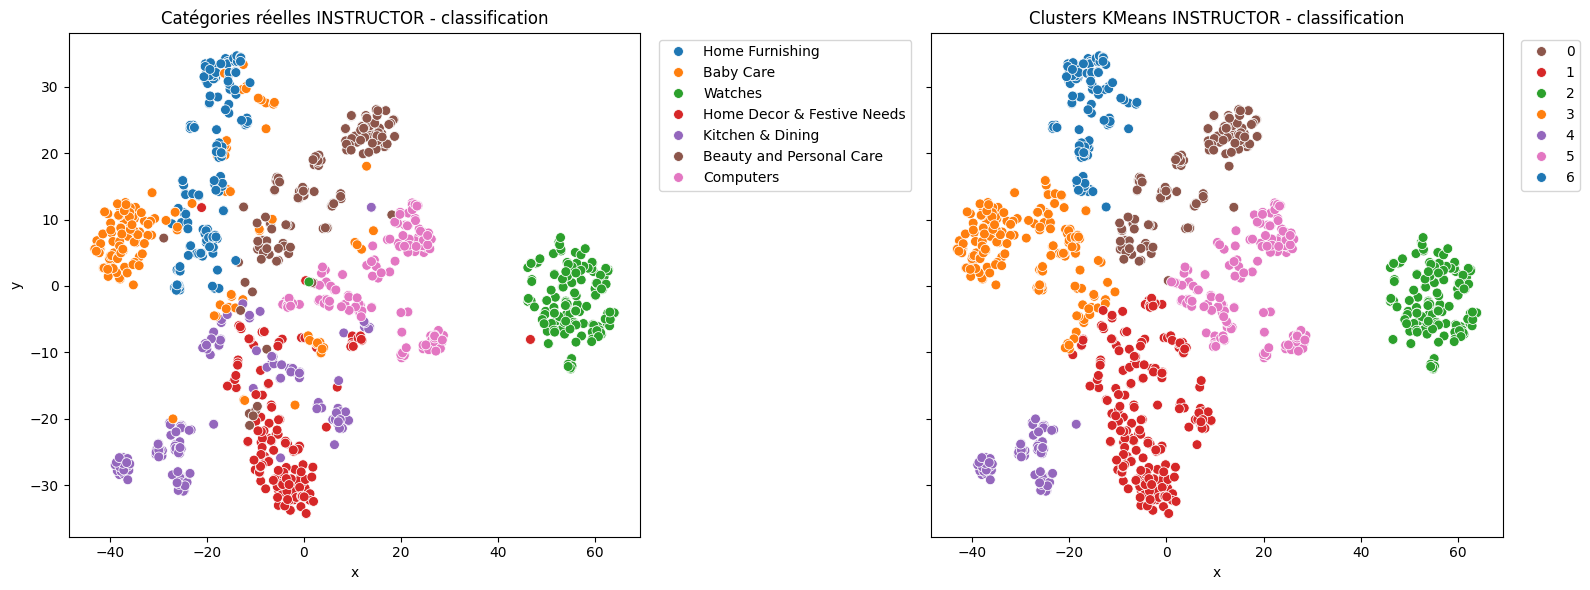


Instruction : category_classification
load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

max_seq_length  512


Batches: 100%|██████████| 33/33 [01:42<00:00,  3.11s/it]


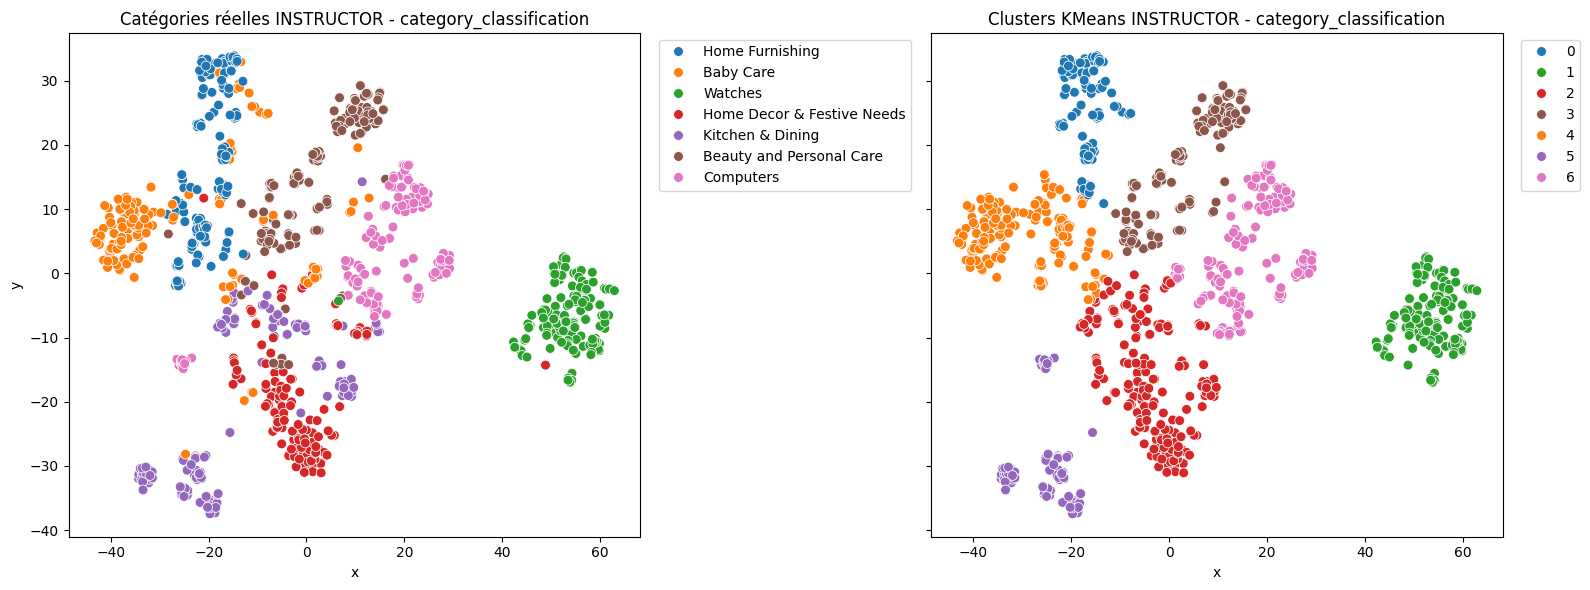


Instruction : ecommerce
load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

max_seq_length  512


Batches: 100%|██████████| 33/33 [01:52<00:00,  3.41s/it]


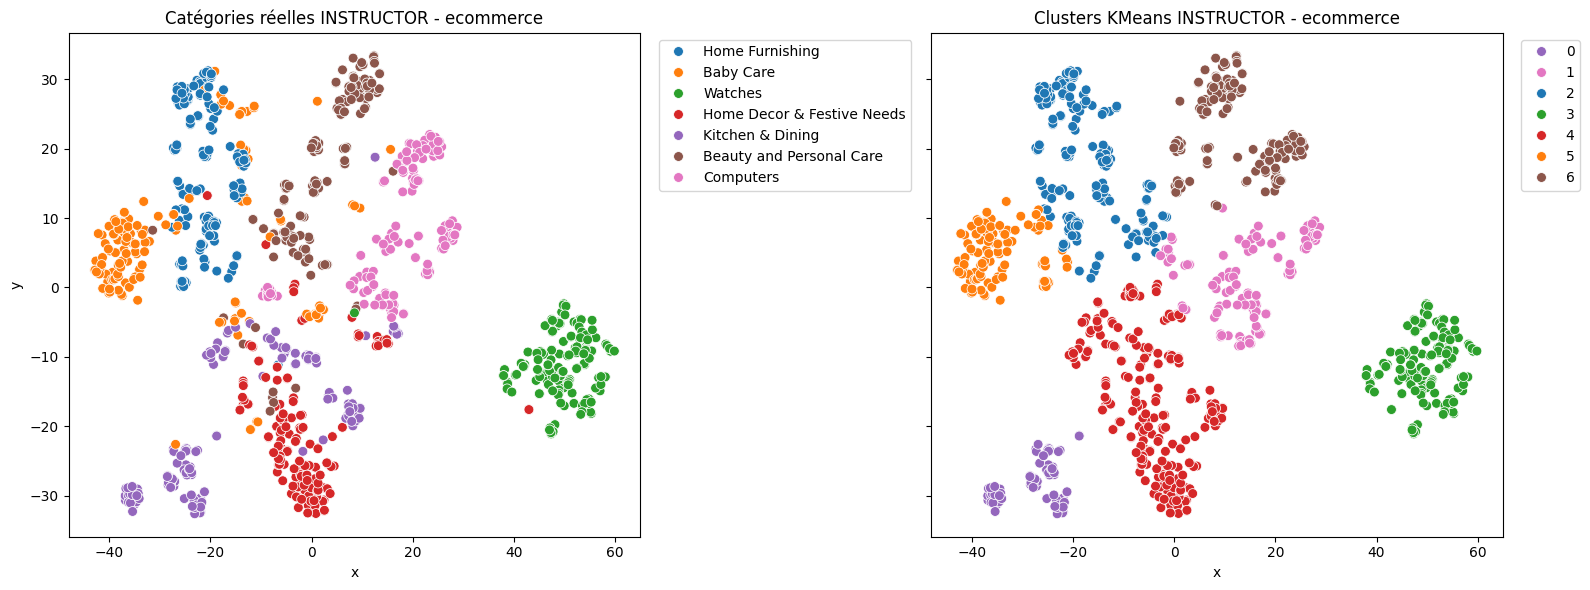


Instruction : semantic
load INSTRUCTOR_Transformer


c:\Users\marga\Documents\Openclassrooms\_Projet_8\.venv_p8_py310\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

max_seq_length  512


Batches: 100%|██████████| 33/33 [02:14<00:00,  4.08s/it]


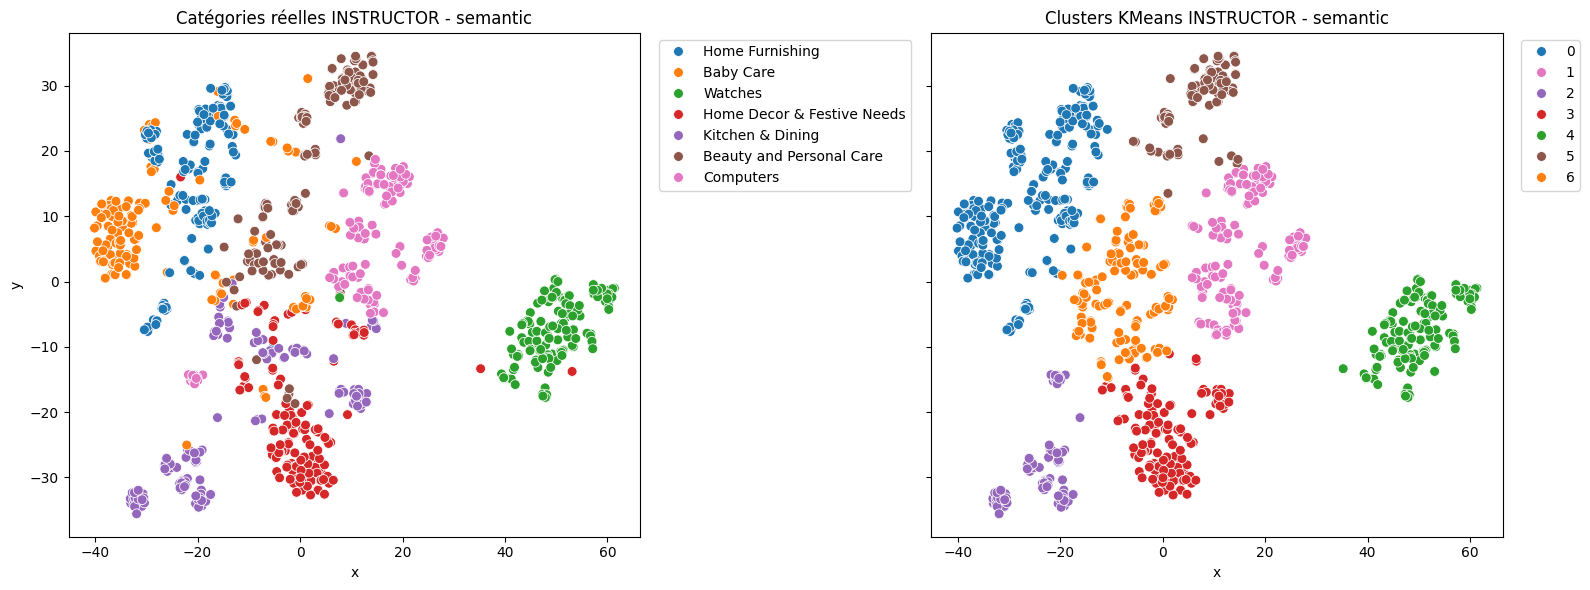

In [55]:
results_instr = []

for name, instr in INSTRUCTIONS.items():
    print(f"\nInstruction : {name}")

    X_emb, t_emb = instructor_pipeline(
        X_text,
        instruction=instr
    )

    res = run_clustering_pipeline(
        X=X_emb,
        y_true=y,
        k=7,
        title=f"INSTRUCTOR - {name}"
    )

    results_instr.append({
        "instruction": name,
        "instruction_text": instr,
        "ARI": res["ari"],
        "time_total_s": t_emb + res["time_total_s"]
    })


In [56]:
# Comparaison des résultats 
df_instr = pd.DataFrame(results_instr).sort_values("ARI", ascending=False)
df_instr

,instruction,instruction_text,ARI,time_total_s
2,category_classification,Represent the product description for product ...,0.621749,106.937975
1,classification,Represent the product description for classifi...,0.605740,387.847788
0,generic,Represent the product description,0.583598,144.296110
4,semantic,Represent the semantic meaning of the product ...,0.575653,139.744610
3,ecommerce,Represent an e-commerce product description fo...,0.509088,116.809942


### **6. Comparaison des performances**

In [42]:
pd.DataFrame({
    "Modèle": ["SBERT", "INSTRUCTOR"],
    "ARI": [ari_sbert, ari_instr],
    "Temps total (s)": [time_sbert_total, time_instr_total]
})

,Modèle,ARI,Temps total (s)
0,SBERT,0.611705,20.174333
1,INSTRUCTOR,0.621749,110.810332


Les deux modèles produisent une structuration sémantique cohérente des descriptions produits, avec des scores ARI proches (0.61 pour SBERT, 0.62 pour INSTRUCTOR).
Le gain marginal observé avec INSTRUCTOR s’accompagne toutefois d’un temps d’exécution plus de cinq fois supérieur, ce qui limite son intérêt opérationnel dans ce contexte mono-domaine.
SBERT apparaît ainsi comme le meilleur compromis performance / coût computationnel pour ce cas d’usage.

### **7. Interprétabilité globale et locale**

Dans le cas de modèles d’embeddings non supervisés, la notion de feature importance ne correspond pas à des poids associés à des variables explicites, mais à l’analyse des structures sémantiques apprises par le modèle. L’interprétabilité repose alors sur l’identification des concepts dominants au sein des clusters et sur l’analyse locale de la proximité des observations.

#### 7.1. Interprétabilité globale

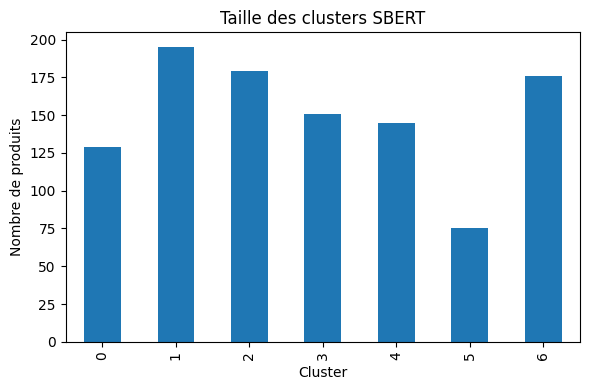

In [43]:
cluster_counts = (
    res_sbert["df_visu"]["cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind="bar")
plt.title("Taille des clusters SBERT")
plt.xlabel("Cluster")
plt.ylabel("Nombre de produits")
plt.tight_layout()
plt.show()


Les clusters obtenus avec SBERT présentent des tailles relativement équilibrées, sans cluster dominant ni cluster résiduel marginal.
Cette répartition homogène indique que le modèle ne regroupe pas artificiellement un grand nombre de produits hétérogènes dans un même cluster.
Elle suggère également une structuration stable de l’espace sémantique, favorable à l’interprétation globale des résultats.

In [44]:
df_clusters = res_sbert["df_visu"].copy()
df_clusters["text"] = data.loc[df_clusters.index, "text_clean"]


In [45]:
def top_words_by_group(df, group_col, text_col, n=10):
    results = {}

    for g in sorted(df[group_col].unique()):
        texts = df.loc[df[group_col] == g, text_col]
        tokens = []
        for t in texts:
            tokens.extend(tokenize_for_eda(t))
        results[g] = Counter(tokens).most_common(n)

    return results


In [46]:
top_words_clusters = top_words_by_group(
    df_clusters,
    group_col="cluster",
    text_col="text",
    n=10
)

top_words_clusters


{np.int32(0): [('buy', 91),
  ('products', 89),
  ('free', 89),
  ('genuine', 88),
  ('shipping', 88),
  ('cash', 88),
  ('delivery', 88),
  ('cotton', 64),
  ('towel', 55),
  ('single', 54)],
 np.int32(1): [('showpiece', 206),
  ('products', 121),
  ('best', 115),
  ('free', 108),
  ('buy', 104),
  ('prices', 102),
  ('day', 102),
  ('delivery', 98),
  ('online', 97),
  ('shipping', 97)],
 np.int32(2): [('baby', 312),
  ('cotton', 231),
  ('fabric', 188),
  ('details', 182),
  ('specifications', 168),
  ('girl', 163),
  ('general', 158),
  ('pack', 150),
  ('features', 144),
  ('package', 141)],
 np.int32(3): [('watch', 324),
  ('analog', 252),
  ('men', 158),
  ('day', 138),
  ('buy', 136),
  ('online', 136),
  ('genuine', 136),
  ('products', 136),
  ('replacement', 136),
  ('guarantee', 136)],
 np.int32(4): [('products', 142),
  ('free', 122),
  ('genuine', 114),
  ('shipping', 114),
  ('cash', 114),
  ('delivery', 114),
  ('buy', 110),
  ('replacement', 110),
  ('day', 106),
  ('g

L’analyse des mots dominants par cluster montre que les regroupements sont portés par des champs lexicaux cohérents avec les catégories produits. Les clusters correspondant à des catégories spécifiques (Watches, Baby Care, Computers) présentent un vocabulaire distinctif, tandis que les catégories plus générales partagent un lexique commercial commun (buy, free, delivery), expliquant les chevauchements observés. Cette analyse confirme que les clusters sont sémantiquement interprétables.

#### 7.2. Interprétabilité locale

In [47]:
from sklearn.metrics.pairwise import euclidean_distances

X_tsne = res_sbert["df_visu"][["x", "y"]].values
labels = res_sbert["df_visu"]["cluster"].values

centroids = np.vstack([
    X_tsne[labels == k].mean(axis=0)
    for k in sorted(np.unique(labels))
])

distances = euclidean_distances(X_tsne, centroids)

res_sbert["df_visu"]["dist_to_centroid"] = [
    distances[i, label] for i, label in enumerate(labels)
]


In [48]:
example = (
    res_sbert["df_visu"]
    .sort_values("dist_to_centroid")
    .iloc[0]
)

example

x                   39.290291
y                     12.5242
category              Watches
cluster                     3
cluster_aligned       Watches
dist_to_centroid     0.458173
Name: 524, dtype: object

In [49]:
data.loc[example.name, ["description", "main_category"]]

description      Noise NOSWW001 Analog Watch  - For Men, Women ...
main_category                                              Watches
Name: 524, dtype: object

In [52]:
print(data.loc[example.name, "description"])

Noise NOSWW001 Analog Watch  - For Men, Women - Buy Noise NOSWW001 Analog Watch  - For Men, Women  NOSWW001 Online at Rs.999 in India Only at Flipkart.com. Round Dial, Blue Strap, Water Resistant - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


Ce produit est très proche du centroïde de son cluster (distance = 0.46), ce qui indique qu’il est hautement représentatif du groupe.
Sa description contient des termes caractéristiques de la catégorie Watches (watch, analog, men), expliquant son positionnement central dans le cluster associé.
Cet exemple illustre que le modèle regroupe correctement les produits dont le contenu textuel correspond fortement au champ sémantique dominant du cluster.

In [50]:
outlier = (
    res_sbert["df_visu"]
    .sort_values("dist_to_centroid", ascending=False)
    .iloc[0]
)

data.loc[outlier.name, ["description", "main_category"]]


description      Buy Wallmantra Medium Vinyl Sticker Sticker fo...
main_category                                            Baby Care
Name: 1048, dtype: object

In [53]:
outlier

x                                   3.303764
y                                  -2.380869
category                           Baby Care
cluster                                    4
cluster_aligned     Beauty and Personal Care
dist_to_centroid                   15.897853
Name: 1048, dtype: object

In [51]:
print(data.loc[outlier.name, "description"])

Buy Wallmantra Medium Vinyl Sticker Sticker for Rs.1333 online. Wallmantra Medium Vinyl Sticker Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


Ce produit est éloigné du centroïde de son cluster, ce qui indique un positionnement atypique dans l’espace sémantique.
Bien que rattaché à la catégorie Baby Care, sa description (vinyl sticker, wall, decor) relève davantage du champ lexical de la décoration intérieure que des produits pour bébés.
Ce décalage sémantique explique son positionnement en bordure de cluster et illustre une limite liée au contenu textuel plutôt qu’à un défaut du modèle.

### **8. Discussion des résultats**

Cette étude a permis de comparer deux approches d’embeddings textuels dans un cadre non supervisé : SBERT (baseline) et INSTRUCTOR (modèle récent orienté par instruction).
Les résultats montrent que les deux modèles parviennent à structurer l’espace sémantique des descriptions produits de manière cohérente, avec des scores ARI proches (0.61 pour SBERT, 0.62 pour INSTRUCTOR).

Les visualisations t-SNE confirment que les catégories les plus spécifiques (Watches, Computers, Baby Care) forment des clusters compacts et bien séparés, tandis que les catégories plus générales (Home Furnishing, Home Decor & Festive Needs, Kitchen & Dining) présentent des chevauchements partiels. Ces confusions sont cohérentes avec la proximité sémantique réelle des produits et reflètent davantage les limites du vocabulaire descriptif que celles des modèles.

D’un point de vue opérationnel, SBERT apparaît comme le meilleur compromis. Bien qu’INSTRUCTOR atteigne un ARI légèrement supérieur, ce gain marginal s’accompagne d’un temps d’exécution nettement plus élevé, rendant son usage moins pertinent dans ce contexte mono-domaine et mono-tâche.